# Supplementary Notebook for PhD Thesis:
## Title: *Direct and Indirect Energy Flexibility Interactions at the Building and Community Scale: From system to Human-Interfaced Systems


>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](../images/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2FNanaKofi%2Fpredis_indirect_flexibility/master?labpath=Indirect_flex_assessment.ipynb)  

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.
    

The goal of this study is to evaluate the impact of indirect flexibility, in this case community of EV users in the GReEN-ER building (Grenoble INP) and subsequently provide a methodology for sizing stationary batteries taking into account this indirect flexibility. A factsheet of this study is available in the end the notebook, in the Factsheet section.



For all intents and purposes, the diagram below represents the system being evaluated.

### Pictorial View of the building

![green-er.png](../images/green-er.png)

## Data specifications
>### Predis-MHI
|#|Key |Description |
|---|---|---|
| 1 | name |Predis_data_2020_2022.csv | 
| 2 | title |Predis-MHI electricity consumption and production datatsets | 
| 3 | id | |
| 4 | description |dataset containing the demand profiles <br> (building and 4 charging stations) and the solar PV (22kWp) production profiles <br>  collected from the Building Management System of GreEn-ER |
| 5 | language | en-US |
| 6 | subject |Reference the topic of the resource in ontology terms  |
| 7 | keywords |Smart Building, <br>Living Lab,<br>Building energy data] |
| 8 | publicationDate | (2023-07-17) |
| 9 | context |Used in a study to assess the impact of <br> indirect flexiblty on the perfrmance of a building's energy system  |
| 10 | spatial | France  | 
| 11 | temporal |2020-01-01 to 2022-12-31  |
| 12 | source |G2ELab |
| 13 | licenses |CC By 4.0  |
| 14 | contributors |Nana Kofi Twum-Duah, Frederic Wurtz, Stéphane Ploix, Manar Amayri |
| 15 | resources |individual file  |
| 16 | resolution |1 hour | 



### Relevant imports

to run this notebook, the following libraries are required

* pandas Version => 1.2.4
* numpy Version => 1.19.5
* plotly Version => 4.14.1
* Pyomo Version ==  6.0.1

### Note
This note book will not run if you do not install the dependancies, you can do that in the next cell <br>
``os.system('pip install -e .')`` in the next cell is not required if you have already done this in terminal<br>
if you need to install the dependancies, uncomment the entire code block

 

In [1]:
import os

work_path = os.getcwd()
########################################################
# #uncomment to install dependencies
# print (work_path)
# os.chdir("../")


# work_path = os.getcwd()

# print (work_path)

# os.system('pip install -e .')

# os.chdir(f"{work_path}\\notebooks")

# work_path = os.getcwd()

# print (work_path)
##################################################
# os.system('pip install ')
###Necessary for glpk to  work on binder (if not on binder comment out next line)
# os.system('conda install -c conda-forge glpk')

### NOTE

The ``show_plots`` parameter is to allow for the plots to bre rendered in the GitLab repository (GitLab does not render html plots). If you want an interactive notebook set it to ``False`` and rerun the entire notebook.



Alternatively, an HTML version of this notebook is provided in the folder **html_files**

In [2]:
show_plots = True

In [3]:
import pandas as pd
import numpy as np


import plotly.express as px
import plotly.subplots as sp

from IPython.display import clear_output



from tools.assessment_tools import optimization, data_manager
%load_ext autoreload
%autoreload 2

In [4]:
## Method to calculate the selfconsumption rate for a given period
def autocon(consumption: list, production: list,stockage: list):  # In Auto consumption value1=consumption, value2=production, value3 stockage

    total_consumption = 0
    total_production = 0
    value_accumulator = 0
    for i in range(len(consumption)):
        total_consumption = total_consumption + consumption[i]
        total_production = total_production + production[i]
        value_accumulator += min(production[i] - stockage[i], consumption[i])

    if total_consumption == 0 and total_production != 0:
        return 1
    if total_production == 0:
        return 0
    else:
        print (value_accumulator , total_production)
        return value_accumulator / total_production

## Read & Plot Data

All data has been collated and put in a single CSV (```Predis_data_2021.csv```) file for simplicity and ease of use.

csv file (or data frame) should have the following columns:

* production :  PV production data
* Consumption :  demand/ consumption data (without the indirect flexibility)
* Indirect flexibility: for this use case the EV charging data:

    * charger 1 
    * charger 2 
    * charger 3
    * charger 4


In [5]:
pv = "production"
demand = "Consumption"
indirect_flex = ["charger 1" , "charger 2","charger 3" , "charger 4"]

In [6]:
# data = pd.read_csv("data/Predis_data_2021.csv", sep=",", decimal=".", header=0,
#                    encoding = "UTF-8",na_values = "NaN")
# data['Datetime']= pd.to_datetime(data['Datetime'],dayfirst = False)
# data = data.set_index("Datetime")



# data = data.fillna(0)

In [7]:
data = pd.read_csv("../data/Predis_data_2020_2022.csv", sep=",", decimal=".", header=0,
                   encoding = "UTF-8",na_values = "NaN")
data['Datetime']= pd.to_datetime(data['Datetime'],dayfirst = False)



data = data.set_index("Datetime")
data = data[data.index >= '2021-01-01 00:00:00']
data = data[data.index <= '2021-12-31 23:55:00']


data = data.fillna(0)

In [8]:
d_manager = data_manager.DataManager()
optimizer = optimization.Optimize(pv = pv, demand = demand , indirect_flex = indirect_flex )

## Visualization of charging data (chargers 1 & 2)

* There are instantaneous charging power values in excess of the 14kW nominal rated power of the chargers.
    * this phenomenon is due to the fact that cummlative energy meters are used, and communication issues  do exist in the system. i.e. a large surge in the energy usage after communication is  restored.
* in order to solve this issue a simple apporach is used, where the excess values are spread over the previous 3 hours.


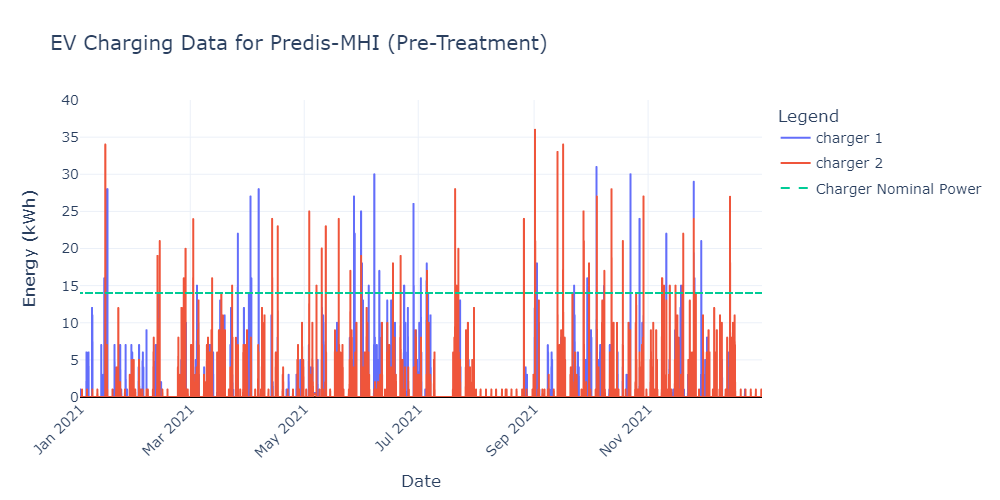

In [9]:
layout = {
   "font":{"size" : 14}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black','tickangle' : -45},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left',
              "range": [0, 40], "dtick": 5},
    "legend": {"tracegroupgap":4 ,"font_size": 14,"title" : "Legend"}
            }


data["nominal"] = [14] * len(data)
fig = px.line(data[["charger 1", "charger 2","nominal"]],title =
              "EV Charging Data for Predis-MHI (Pre-Treatment)")
fig.data[-1].name = "Charger Nominal Power"
fig.data[-1].line.dash = "dash"
fig.layout.xaxis.title="Date"


fig.update_yaxes(title_text="Energy (kWh)", secondary_y=False)
fig.update_layout(layout)
if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

## Charging data - after processing 

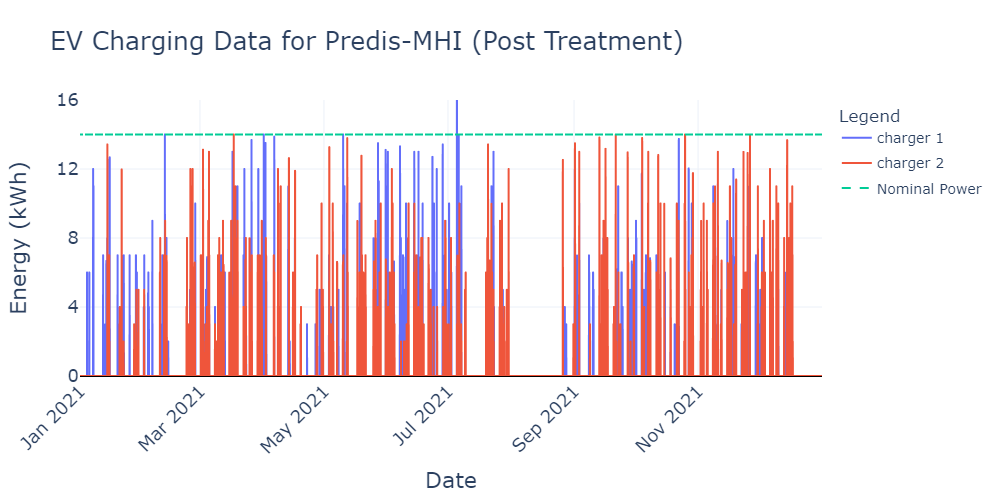

In [10]:
layout = {
   "font":{"size" : 18}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black','tickangle' : -45},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left',
              "range": [0, 16], "dtick": 4},
    "legend": {"tracegroupgap":4 ,"font_size": 14,"title" : "Legend"}
}


data_treated =  d_manager.correction(df=data.drop(columns = "nominal").copy(),cols = ["charger 1", "charger 2"])

data_treated.where(data_treated[indirect_flex] > 1, 0, inplace=True)


data_treated["nominal"] = [14] * len(data_treated)
fig = px.line(data_treated[["charger 1", "charger 2",'nominal']],title = 
              "EV Charging Data for Predis-MHI (Post Treatment)")
fig.data[-1].name = "Nominal Power"
fig.data[-1].line.dash = "dash"
fig.layout.xaxis.title="Date"


fig.update_yaxes(title_text="Energy (kWh)", secondary_y=False)
fig.update_layout(layout)
if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

In [11]:
data_treated = data_treated.drop(columns = "nominal")

data_treated["total_consumption"] = data_treated[demand] + data_treated[indirect_flex].sum(axis=1)

data_treated["import"] = data_treated["total_consumption"] - data_treated[pv] 

data_treated["import"] = data_treated["import"].clip(lower=0)

data_treated["total_consumption"].fillna(value = 0, inplace=True)

## Visualization of complete data set.

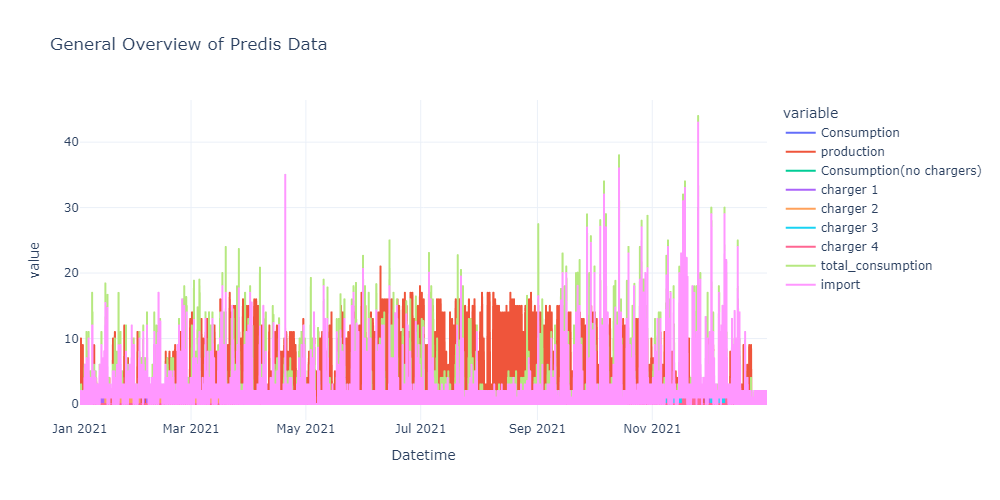

In [12]:

fig = px.line(data_treated, x=data_treated.index, y=data_treated.columns,title = "General Overview of Predis Data",
              template = "plotly_white")
if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()


### Natural self-consumption
* self-consumption of a building without any technical interventions such as batteries or load shifting 

In [13]:
print ('The natural self-consumption of the platform was: ',
       (data_treated["total_consumption"] - data_treated["import"]).sum() / data_treated[pv].sum())

The natural self-consumption of the platform was:  0.45633597716278984


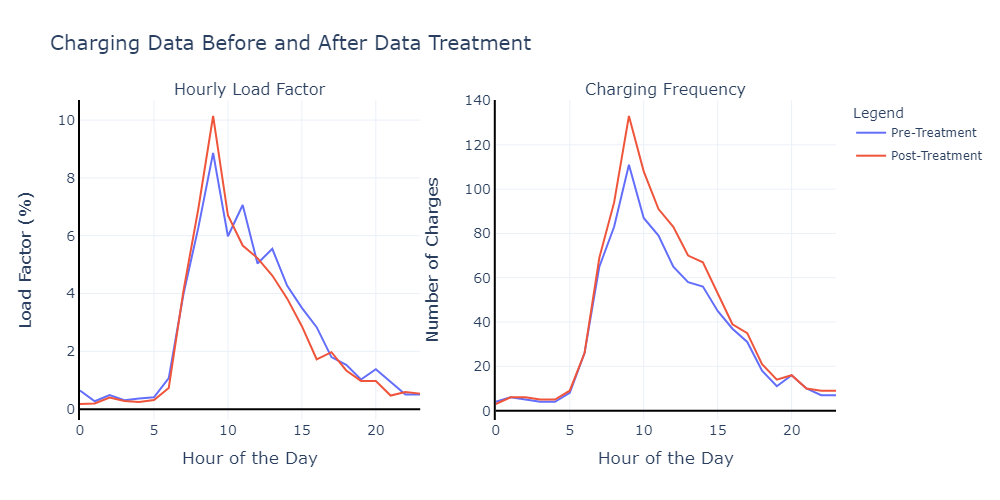

In [14]:
layout = {
   "font":{"size" : 14}, "template": "plotly_white",
    'xaxis': {#"showline": False,"linecolor": "black", "linewidth": 2,
              'zerolinecolor':'black',"title_text" : "Hour of the Day",
             },
    'xaxis2': {#"showline": True,"linecolor": "black", "linewidth": 1,
              "title_text" : "Hour of the Day",
             },
    "yaxis": {"showline": True,"linecolor": "black", "linewidth": 2,
              'zerolinecolor':'black',
               "side": 'left',
              "title_text" : "Load Factor (%)",

    },
    "yaxis2": {"showline": True,"linecolor": "black", "linewidth": 2,
               'zerolinecolor':'black',
               "side": 'left',
               "title_text" : "Number of Charges",
               "overlaying": 'y',
    },
    "legend" : {"tracegroupgap":4 ,"font_size": 12,
                "title" : "Legend"}
}

temp = data.copy()


temp_ = data_treated.copy()


b4 = (temp[indirect_flex].sum(axis=1)).tolist()
af = (temp_[indirect_flex].sum(axis=1)).tolist()

df = pd.DataFrame({"Pre-Treatment" :b4 , "Post-Treatment": af},index = temp.index)


fig = px.line((df.groupby(df.index.hour).mean()/28)*100, template = 'plotly_white',
              title =  "EV Charging Data for Predis-MHI")


temp.where(temp > 1, np.nan, inplace=True)
temp_.where(temp_ > 1, np.nan, inplace=True)

df_group_o = temp[indirect_flex].groupby(temp.index.hour).count()
df_group = temp_[indirect_flex].groupby(temp_.index.hour).count()

b4 = (df_group_o[indirect_flex].sum(axis=1)).tolist()
af = (df_group[indirect_flex].sum(axis=1)).tolist()


df = pd.DataFrame({"Pre-Treatment" :b4 , "Post-Treatment": af})

fig2 = px.line(df, template = 'plotly_white')

    
figure = sp.make_subplots(rows=1, cols=2,subplot_titles=
                          ("Hourly Load Factor", "Charging Frequency",)) 


figure.add_traces(fig.data, rows = 1, cols = 1)
figure.add_traces(fig2.data, rows = 1, cols = 2)
for i in range (2):
    figure.data[i].showlegend = False

#the subplot as shown in the above image
figure.update_layout(layout, title = "Charging Data Before and After Data Treatment")
if show_plots:

    figure.show("png",width = 1000)
    
else:
    figure.show()

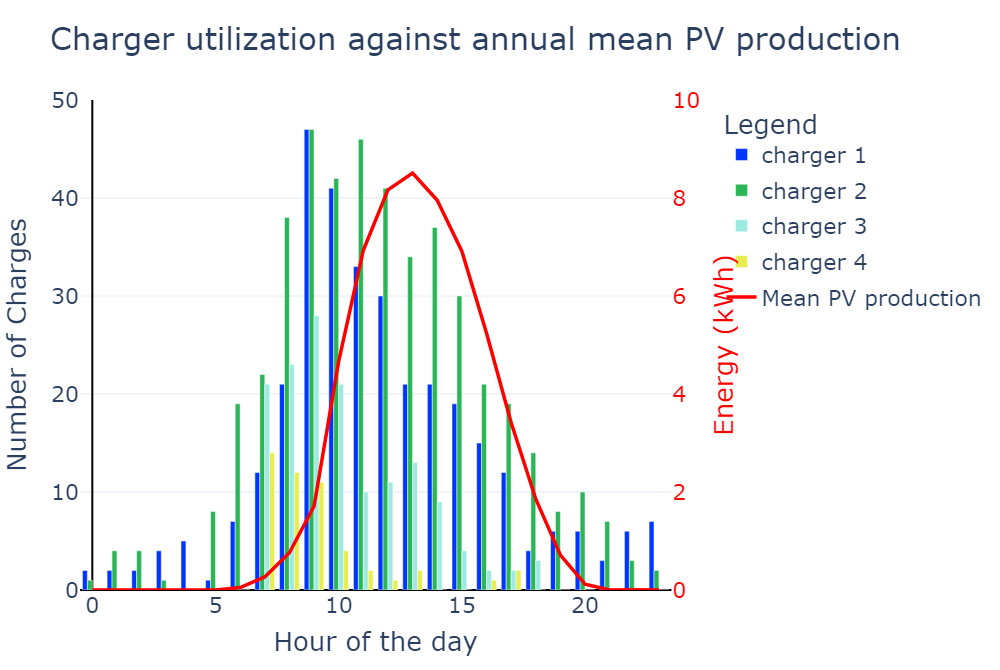

In [15]:
layout = {"height" : 670 , "width": 1200,
   "font":{"size" : 22},
    'xaxis': {'zerolinewidth': 2,
              'zerolinecolor':'black'
             },
    "yaxis": {'zerolinewidth': 2,
              'zerolinecolor':'black',
               "side": 'left',
              "range": [0, 50],
              "dtick": 10
    },
    "yaxis2": {'zerolinewidth': 2, 
               'zerolinecolor':'black',
               "side": 'right',
               "range": [0, 10],
               "overlaying": 'y',
               "dtick": 2
    },
    "legend" : {"tracegroupgap":4 ,"font_size": 22,
                "title" : "Legend"}
}

temp = data_treated.copy()
temp.where(temp > 1, np.nan, inplace=True)

df_group = temp[indirect_flex].groupby(temp.index.hour).count()
fig = px.bar(df_group, template = 'plotly_white', barmode = "group",color_discrete_sequence=["#0035FF","#2AB656","#9CEAE1",
                                                                                            "#E7EE52"])

subfig = sp.make_subplots(specs=[[{"secondary_y": True}]])

fig_2 = px.line(data_treated[pv].groupby(data_treated.index.hour).mean())

fig_2.data[-1].name = "Mean PV production"
fig_2.data[-1].line.color = "#FF0000"
fig_2.data[-1].line.width = 3.5
fig_2.update_traces(yaxis="y2")


subfig.add_traces(fig.data + fig_2.data)
subfig.layout.xaxis.title="Hour of the day"


subfig.update_yaxes(title_text="Number of Charges", secondary_y=False)
subfig.update_yaxes(title_text="Energy (kWh)", color = "#FF0000" , secondary_y=True)
subfig.update_layout(layout , template = 'plotly_white', title = "Charger utilization against annual mean PV production")

if show_plots:

    subfig.show("png",width = 1000)
    
else:
    subfig.show()

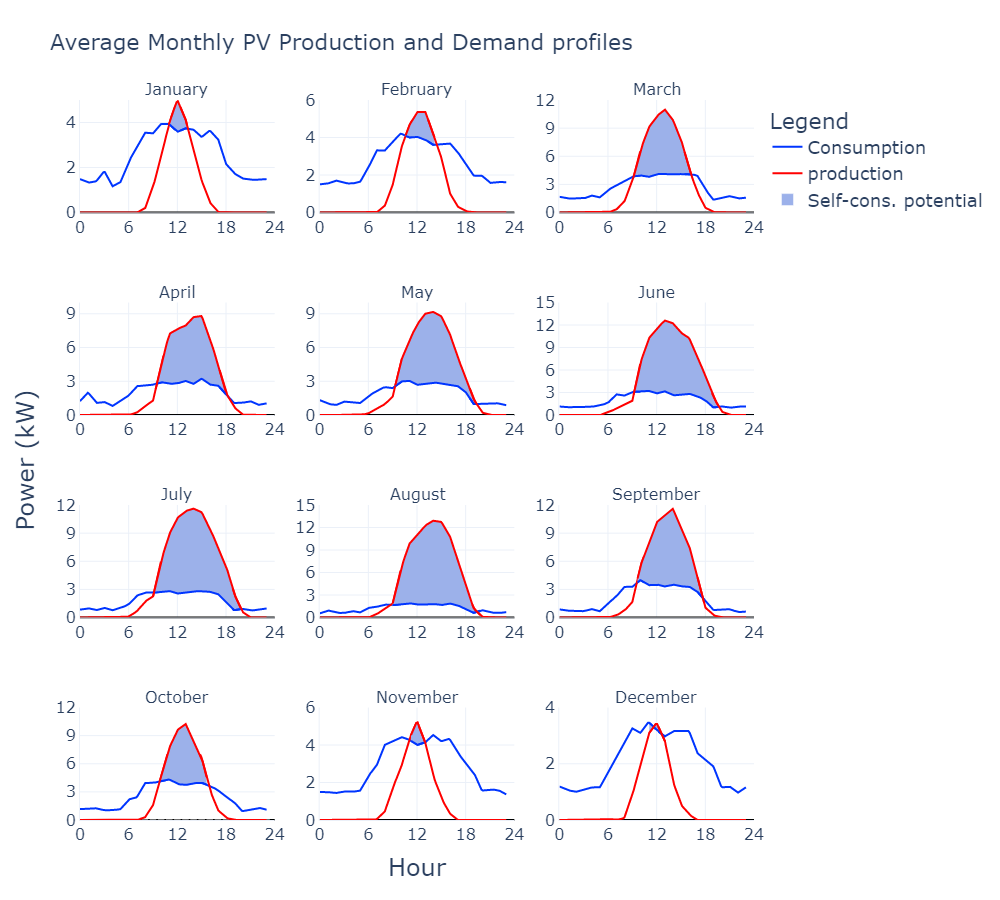

In [16]:
layout = {
    "height" : 900,"width" : 1200,
    "title":{"font":{"size" : 10}},
   "font":{"size" : 16},
    "legend" : {"tracegroupgap":4 ,"font_size": 18,"traceorder" : "normal",
                "title" : "Legend"}
}

publish = []

df_group = data_treated[[demand,pv]].groupby([data_treated.index.month,data_treated.index.hour]).mean()
df_group.loc[1]


months = ("January", "February", "March" ,"April" ,
            "May","June","July","August","September",
          "October","November","December")
fine_tune = [[],[11.8,13.3],[11.5,14.3],[10.1,16.4],
            [10.3,18.1],[10.2,19.4],[10.1,19.7],
            [10,19.8],[10,19.8],[10.5,17.9],
            [10.8,15.7],[12.24,13.1],[12,13.1]]

y_max =  [5,6,12,10,10,15,12,15,12,12,6,4]

figure = sp.make_subplots(rows=4, cols=3,subplot_titles= months, y_title = "Power (kW)",
                          x_title = "Hour")
cnt , cols = 1, 1
for i in range (1,13,1):
    if i < 4:
        rows = 1
    elif i < 7 and i >3: 
        rows = 2
    elif i < 10 and i >6: 
        rows = 3
    else:
        rows = 4
    Xresampled =  np.linspace(0,23,48*3)
    df_resampled = df_group.loc[i].copy().reindex(df_group.loc[i].index.union(Xresampled)).interpolate('values').loc[Xresampled]

    fig = px.line(df_resampled.loc[0:fine_tune[i][0]], template = 'plotly_white',color_discrete_sequence=["#0035FF","#FF0000"])
    fig1 = px.line(df_resampled.loc[fine_tune[i][0]-1:fine_tune[i][1]], template = 'plotly_white',color_discrete_sequence=["#0035FF","#FF0000"])
   
    fig.add_trace(fig1.data[0])
    fig.add_trace(fig1.data[1])

    fig.data[-1].fill = 'tonexty'
    fig.data[-1].fillcolor='#9CB1EA'

    fig1 = px.line(df_resampled.loc[fine_tune[i][1]-1:23], template = 'plotly_white',
                   color_discrete_sequence=["#0035FF","#FF0000"])
    fig.add_trace(fig1.data[0])
    fig.add_trace(fig1.data[1])
    
   
    figure.add_traces(fig.data ,rows = rows , cols = cols)
    if i == 6 or i == 12:
        publish.append(fig)

    if y_max[i-1] <9:
        tick = 2
    else:
        tick = 3
    layout[f"yaxis{i}"]=  {'zerolinewidth': 2,  'zerolinecolor':'black',"showline": True,
                           "side": 'left',"range": [0, y_max[i-1]],
                           "overlaying": 'y',"dtick": tick}
    
    layout[f'xaxis{i}'] =  {'zerolinewidth': 2,"showline": True,
              'zerolinecolor':'black',"range": [0,24],"dtick" : 6
             }
            
    cols += 1
    if cols >= 4:
        cols = 1
    

    
for trace in range(len(figure["data"])):
    
    if trace <= 1 :
        figure.data[trace].showlegend = True
    
    else:
        figure.data[trace].showlegend = False
    
fig = px.bar(pd.DataFrame({"Self-cons. potential": [0]*24}), color_discrete_sequence = ["#9CB1EA"])  
figure.add_traces(fig["data"][0], rows=rows, cols=cols)

figure.update_layout(layout, template = 'plotly_white', title = "Average Monthly PV Production and Demand profiles" )
figure.layout.annotations[-1].font.size = 24
figure.layout.annotations[-2].font.size = 24

if show_plots:

    figure.show("png",width = 1000)
    
else:
    figure.show()

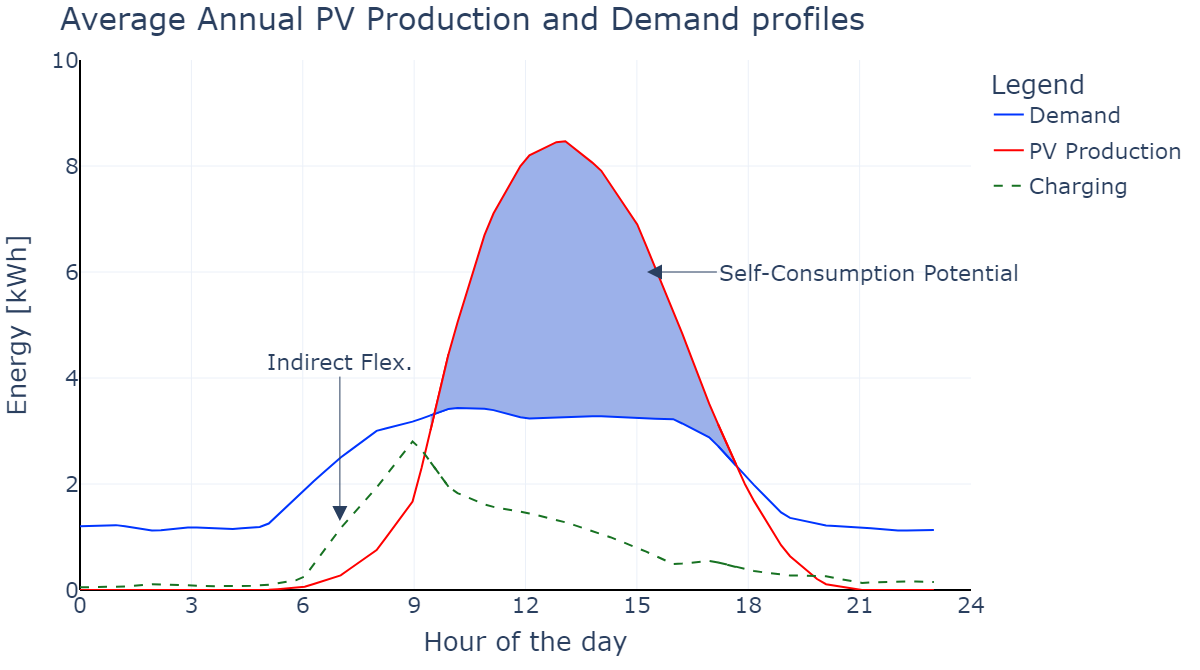

In [17]:
layout = {
    "height" : 670,"width" : 1200,
    "title":{"font":{"size" : 10}},
   "font":{"size" : 22},
    "annotations":[ { "showarrow" : True,
            "x" : 15,
            "y" : 6, "xref":"x", "yref":"y",
            "text" : "Self-Consumption Potential",
            "xshift":10,
            "arrowhead":2,
            "xanchor":"left",
            "ax" : 70,
            "ay" : 0,
            "yanchor":"middle",
            "arrowsize" : 3,
            "opacity":1},
                   
#               { "showarrow" : True, "x" : 0.54, "y" : d_, "xref":"x", "yref":"y",
#             "text" : f"Direct only : {d_} kWh ", "xshift":0, "arrowhead":2, "xanchor":"center",
#             "ax" : 0, "ay" : -75, "yanchor":"top", "arrowsize" : 3, "opacity":1},
                   
            { "showarrow" : True,
            "x" : 7,
            "y" : 1.3, "xref":"x", "yref":"y",
            "text" : "Indirect Flex.",
            "xshift":0,
            "arrowhead":2,
            "xanchor":"center",
            "ax" :0,
            "ay" : -175,
            "yanchor":"top",
            "arrowsize" : 3,
            "opacity":1}],
    
    'xaxis': {'zerolinewidth': 2,
              'zerolinecolor':'black',"range": [0,24],"dtick" : 3
             },
    "yaxis": {'zerolinewidth': 2,
              'zerolinecolor':'black',
               "side": 'left',
              "range": [0, 10],
              "dtick": 2
    },
    "yaxis2": {'zerolinewidth': 2, 
               'zerolinecolor':'black',
               "side": 'right',
               "range": [0, 10],
               "overlaying": 'y',
               "dtick": 2
    },
    "legend" : {"tracegroupgap":4 ,"font_size": 22,
                "title" : "Legend"}
}


df_group = data_treated.copy()
df_group["chargers"] =df_group[indirect_flex].sum(axis=1)
df_group = df_group[[demand,pv,"chargers"]].groupby(data_treated.index.hour).mean()

Xresampled =  np.linspace(0,23,96)
df_resampled = df_group.copy().reindex(df_group.index.union(Xresampled)).interpolate('values').loc[Xresampled]
df_resampled.loc[:1]

fig = px.line(df_resampled.loc[0:10], template = 'plotly_white',color_discrete_sequence=["#0035FF","#FF0000","#177222"])
fig.data[0].name = "Demand"
fig.data[1].name = "PV Production"
fig.data[2].name = "Charging"
fig.data[-1].line.dash = "dash"

fig1 = px.line(df_resampled.loc[9.21:17.7], template = 'plotly_white',color_discrete_sequence=["#0035FF","#FF0000","#177222"])

fig.add_trace(fig1.data[0])
fig.data[-1].showlegend = False
fig.add_trace(fig1.data[1])
fig.data[-1].showlegend = False
fig.add_trace(fig1.data[2])
fig.data[-1].showlegend = False
fig.data[-1].line.dash = "dash"

fig.data[-2].fill = 'tonexty'
fig.data[-2].fillcolor='#9CB1EA'

fig1 = px.line(df_resampled.loc[17:23], template = 'plotly_white',color_discrete_sequence=["#0035FF","#FF0000","#177222"])

fig.add_trace(fig1.data[0])
fig.data[-1].showlegend = False
fig.add_trace(fig1.data[1])
fig.data[-1].showlegend = False
fig.add_trace(fig1.data[2])
fig.data[-1].showlegend = False
fig.data[-1].line.dash = "dash"


fig.layout.xaxis.title="Hour of the day"


fig.update_yaxes(title_text="Energy [kWh]", secondary_y=False)
subfig.update_yaxes(title_text="Energy [kWh]", color = "#FF0000" , secondary_y=True)
fig.update_layout(layout , template = 'plotly_white', title = "Average Annual PV Production and Demand profiles")

if show_plots:

    fig.show("png",width = 1200)
    
else:
    fig.show()

# Optimization Formulation

* objective function : 
\begin{equation}
\text { objective }=\min \left[\text { Capacity }_{\text {battery }}\right]
\end{equation}
<br><br>
Given the following constraints.<br>
* To constrain the bounds of the battery state of charge
\begin{equation}
\operatorname{SOC}_{\text {Min }} \times \text { Capacity }_{\text {battery }} \leq \text { Energy }_{\text {battery }}(\mathrm{p}, \mathrm{t}) \leq \operatorname{SOC}_{\text {Max }} \times \text { Capacity }_{\text {battery }}
\end{equation}
<br><br>
* To compute the available energy in the battery
\begin{equation}
\text { Energy }_{\text {battery }}(p, t)=\text { Energy }_{\text {battery }}(p, t-1) \times\left[1-\Delta_{\text {sd }}\right]+\left[\text { Power }_{\text {battery }}(p, t) \times \eta_{\text {battery }} \times \text { timestep }\right]
\end{equation}
<br><br>
* To ensure continuity between the various periods (p), the battery’s SOC at the end of each period was defined as:
\begin{equation}
\text { Energy }_{b a t t e r y}(p, T+1)=\text { Energy }_{b a t t e r y}(p, T) \times\left[1-\Delta_{s d}\right]+\left[\text { Power }_{b a t t e r y}(p, T) \times \eta_{b a t t e r y} \times \text { timeste } p\right]
\end{equation}
<br><br>
* Starting battery energy for each period:
\begin{equation}
\text { Energy }_{\text {battery }(\mathrm{p}, \mathrm{t})}=\left\{\begin{array}{c}
\text { Energy }_{\text {battery }}(P, T), \text { where } p=0 \text { and } t=0 \\
\text { Energy }_{\text {battery }}(p-1, T+1), \text { where } p>0 \text { and } t=0
\end{array}\right.
\end{equation}
<br>
* to ensure that the battery charging and discharging power stayed within defined safe operating bounds
\begin{equation}
R_{\text {discharge }} \times \frac{\text { Capacity }_{\text {battery }}}{\text { timestep }} \leq \text { Power }_{\text {battery }}(\mathbf{p}, \mathrm{t}) \leq R_{\text {charge }} \times \frac{\text { Capacity }_{\text {battery }}}{\text { timestep }}
\end{equation}
<br><br>
* To ensure that EV charging energy requirement for the dat=y (period) was met: 
\begin{equation}
\text { Energy }_{\text {chargerX }_{\text {original }}}(p)=\sum_{t}^{T} P_{\text {chargerX }}(p, t) \times \text { timestep }
\end{equation}
<br><br>
* and to respect the operating hours of the building 
\begin{equation}
\left[P_{\text {charger } 1}(t)+P_{\text {charger } 2}(t)\right] \times \text { timestep }=0, \quad \text { if } t<T_{\text {open }} \text { or } t>T_{\text {close }}
\end{equation}
<br><br>
* To ensure the self consumption requirement is met
\begin{equation}
\frac{\sum_{p}^{P} \sum_{t}^{T} \text { Power }_{\text {load }}(\boldsymbol{p}, \boldsymbol{t})-\text { Power }_{\text {import }}(\boldsymbol{p}, \boldsymbol{t})}{\sum_{p}^{P} \sum_{t}^{T} \text { Power }_{p v}(\boldsymbol{p}, \boldsymbol{t})}=\boldsymbol{R}_{\text {self-consumption }}
\end{equation}

<br><br>

* and finally to ensure a power balance in the system:

\begin{equation}
\begin{gathered}
\text { Power }_{P V}(p, t)-\text { Power }_{\text {battery }}(p, t)-\left[\text { Power }_{\text {load }}(p, t)+\sum_{x}^{X} \text { Power }_{\text {charger }_{x}}(p, t)\right]+ \\
\text { Power import }(p, t)+\text { Power }_{\text {export }}(p, t)=0
\end{gathered}
\end{equation}

The code for the optimization can be found in the directory
``"root/battery_sizing/optimization.py"``

## Assumptions used 
Using the formulation described above, the assumptions below were used for the sizing:
* ``Horizon``:  365 days (with sub-horizons of 1 day)
* ``Battery storage``:
    *	Maximum charge /discharge power: 80% of nominal capacity
    *	Maximum state of charge: 100%
    *	Minimum state of charge: 20% 
    *	Self-discharge rate: 0.05% per time step (1 hour)
    *	Initial state of charge = Final state of charge 
*	``EV charging station parameters``:
    *	The maximum charge power is 14kW per station
    *	Charging can only occur during the opening hours of the GreEN-ER building (8:00 – 20:00).
    *	Energy originally consumed by the charger must be exactly satisfied by the optimized charging schedule for a given period (24 hours)


Note: Gurobi was used for the optimization, however in the event that you dont have access to Gurobi, ``glpk`` can be used (however it is a slower solver)

## Energy system: 
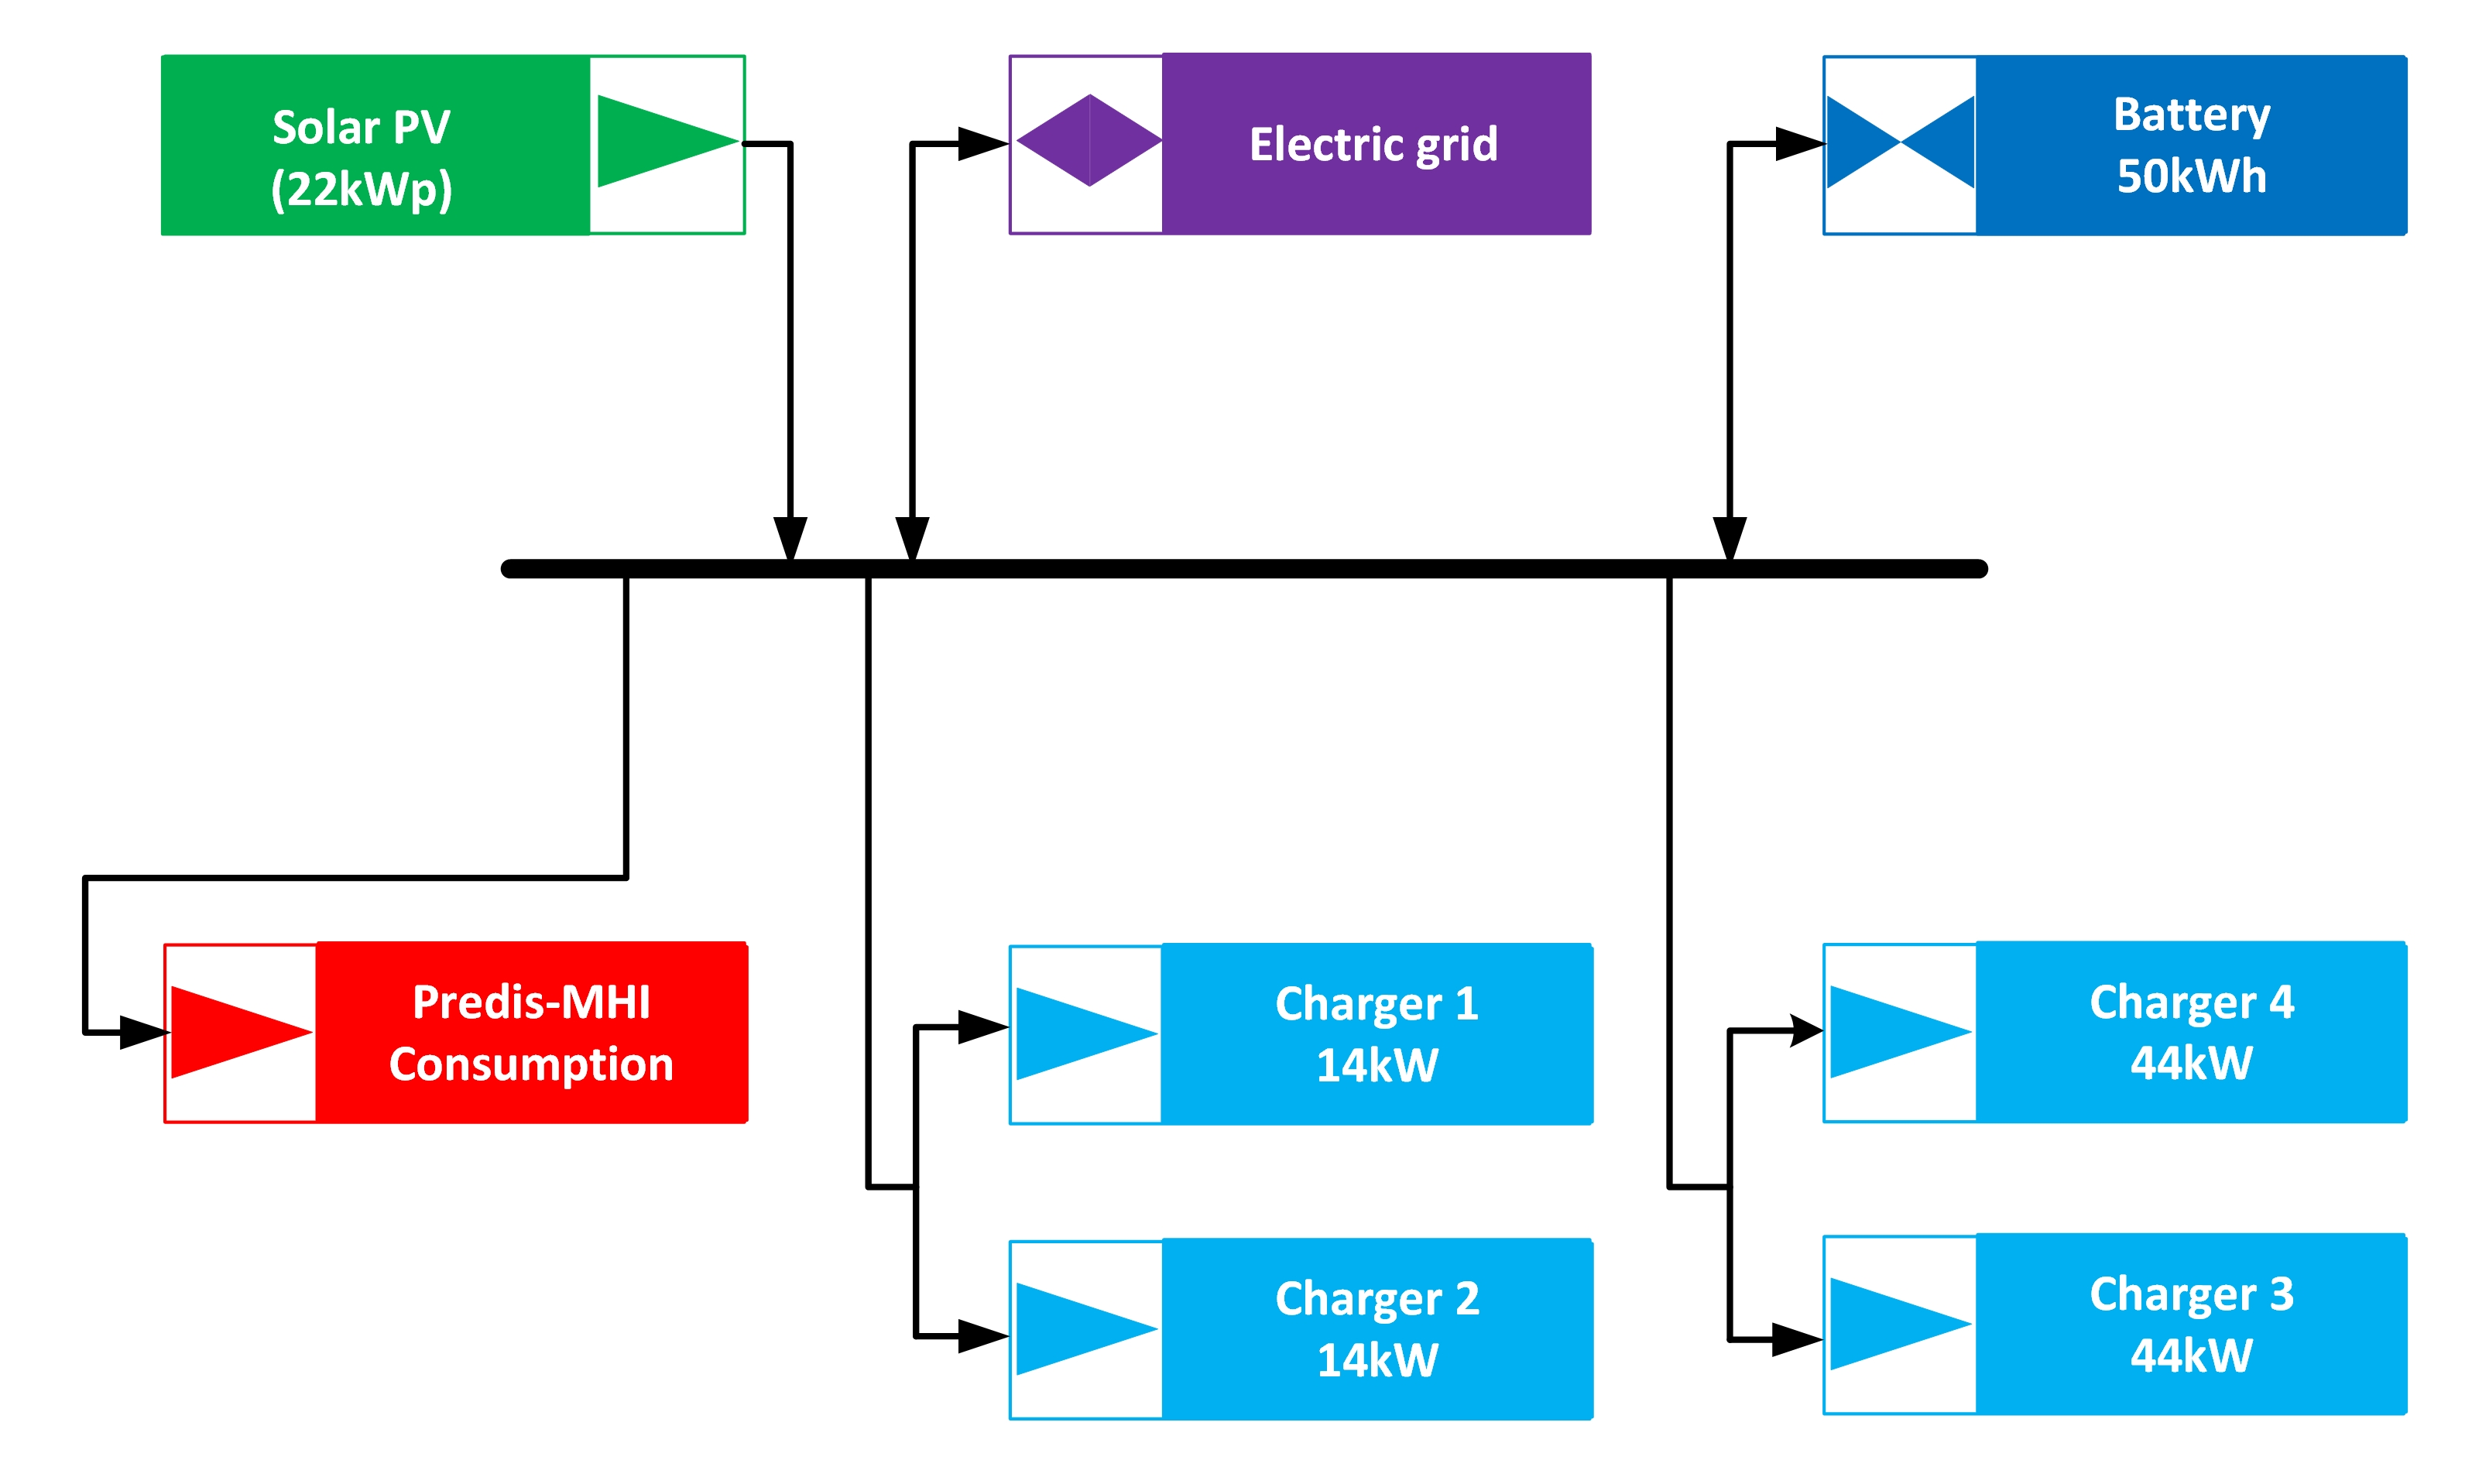

## Optimization problem

In [18]:
"""Convert data fram into a list of data frames
   Each list entry corressponds to a dataframe with 1 days data
   i.e. list  [day1, day2, ....]"""

d = []
for index , frame in data_treated.groupby([(data_treated.index.month),(data_treated.index.day)]):
    d.append(frame)



data_inputs = [d]
temp = data_treated.copy()
temp["Consumption"] = temp["total_consumption"]
temp["charger 1"] = temp["charger 1"] * 0
temp["charger 2"] = temp["charger 2"] * 0
temp["charger 3"] = temp["charger 3"] * 0
temp["charger 4"] = temp["charger 4"] * 0


d = []
for index , frame in temp.groupby([(temp.index.month),(temp.index.day)]):
    d.append(frame)
data_inputs.append(d)  

# Parametric study

* Starting self-consumption: 46%
* Ending self-consumption : 82%

``solver`` is set to "glpk" which is a default solver.
If you have access to gurobi, update ``solver`` with "gurobi" 

In [19]:
self_cons = [i/100 for i in range (44,82,2)]
[]
capacity = {"self-consumption" : self_cons,
            "direct & indirect" : [],
            "direct only" : []}

# carbon = {"self_consumption" : self_cons,
#             "direct & indirect" : [],
#             "direct only" : []}
count = 1
counter = 1
results = {}
tags = ["d" , "d+i"]
for data_input in data_inputs:
    temp,temp_co = [] , []
    for self_con in self_cons:
        
        clear_output(wait=True)
        
        print (f"Current scenario : {counter}")
        print (f"Simulation status {round(counter * 100 /(2 * len(self_cons)))} %")
        counter += 1
        
  # solver arguement is set to "glpk", however if you have gurobi, kindly change "glpk" to "gurobi"
        model,df = optimizer.simulate_cap(data = data_input, sc = self_con,solver = "gurobi")
        df = df.set_index("dates")
        results[f"{tags[count-1]} (sc = {self_con})" ] = df
        temp.append(model.capacity.value)

        
    capacity[list(capacity.keys())[count]] = temp

    
    count += 1


capacity_df  =  pd.DataFrame(capacity)

capacity_df = capacity_df.set_index("self-consumption")




Current scenario : 38
Simulation status 100 %


## Visualization of results

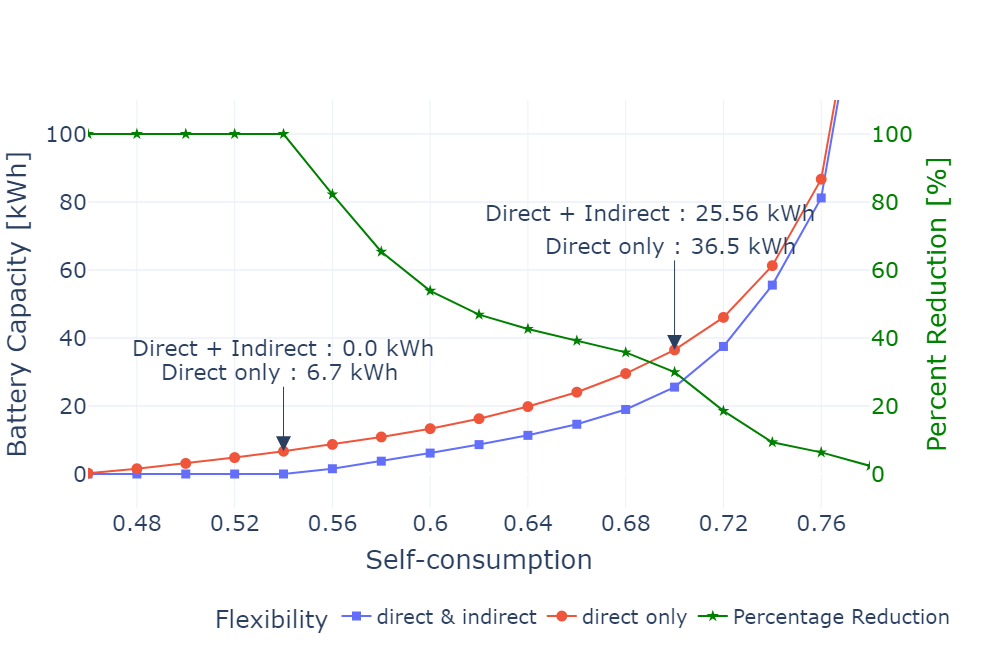

In [20]:
d = round (capacity_df["direct only"].loc[0.70],2)
di = round (capacity_df["direct & indirect"].loc[0.7],2)

d_ = round (capacity_df["direct only"].loc[0.54],2)
di_ = round (capacity_df["direct & indirect"].loc[0.54],2)

layout = {
   "font":{"size" : 22},"width" : 1200, "height" : 650, #"symbol" : 'cross',
#     "marker" : {"size" : 15, "symbol" : 'cross'},
     "annotations":[ 
#          { "showarrow" : True, "x" : 0.42, "y" : 1, "xref":"x", "yref":"y",
#             "text" : "Natural \n self-conumption", "xshift":0, "arrowhead":2, "xanchor":"center",
#             "ax" : 0, "ay" : -92,"yanchor":"top", "arrowsize" : 3, "opacity":1},
                    
             { "showarrow" : True, "x" : 0.54, "y" : d_, "xref":"x", "yref":"y",
            "text" : f"Direct only : {d_} kWh ", "xshift":0, "arrowhead":2, "xanchor":"center",
            "ax" : 0, "ay" : -95, "yanchor":"top", "arrowsize" : 3, "opacity":1},
            
            { "showarrow" : False, "x" : 0.54, "y" : d_+35, "xref":"x", "yref":"y",
            "text" : f"Direct + Indirect : {di_} kWh", "xshift":0, "arrowhead":2, "xanchor":"center",
            "ax" : -120, "ay" : 0,"yanchor":"top", "arrowsize" : 3, "opacity":1},
                    
            
            { "showarrow" : True, "x" : 0.7, "y" : d, "xref":"x", "yref":"y",
            "text" : f"Direct only : {d} kWh ", "xshift":0, "arrowhead":2, "xanchor":"center",
            "ax" : 0, "ay" : -120,"yanchor":"top", "arrowsize" : 3, "opacity":1},
            
            { "showarrow" : False, "x" : 0.69, "y" : d+45, "xref":"x", "yref":"y",
            "text" : f"Direct + Indirect : {di} kWh", "xshift":0, "arrowhead":2, "xanchor":"center",
            "ax" : -140, "ay" : 100,"yanchor":"top", "arrowsize" : 3, "opacity":1},
                  ],
    'xaxis': {'zerolinewidth': 1,
              'zerolinecolor':'black',
              "range": [0.46, 0.78],"dtick": 0.04,
             },
    "yaxis": {'zerolinewidth': 2,
              'zerolinecolor':'white',
               "side": 'left',
              "range": [-10, 110],"dtick": 20, 
              "title_text" : "Battery Capacity [kWh]",
    },
    "yaxis2": {'zerolinewidth': 1,
              'zerolinecolor':'white',
               "side": 'right',
              "range": [-10, 110], "dtick": 20, 
              "title_text" : "Percent Reduction [%]",
    },

    "legend" : {"tracegroupgap":4 ,"font_size": 20,"orientation":"h", "yanchor":"bottom",
    "y":-0.32,"x":0.15, "title" : "Flexibility"}
}

x = [i for i in range (46,78,2)]

fig = px.line(capacity_df[["direct & indirect", "direct only"]] , title = "Optimal battery size considering direct and indirect flexibility", template = "plotly_white", markers=True)
fig.update_layout(layout , hovermode = "x" )
fig['data'][1]['marker']['size'] = 11
fig['data'][0]['marker']['symbol'] = 'square'
fig['data'][0]['marker']['size'] = 9


capacity_df["difference"] =((capacity_df["direct only"] - capacity_df["direct & indirect"]) / capacity_df["direct only"]) *100

fig1 = px.line(capacity_df,x=capacity_df.index , y = "difference",template = "plotly_white", markers=True,
              title = "Percentage change between direct only and direct + indirect", color_discrete_sequence=["green"])
fig1.update_layout(hovermode = "x")
fig1.update_yaxes(title_text="percentage change")
fig1.data[-1].showlegend = True
fig1.data[-1].name = "Percentage Reduction"
fig1['data'][0]['marker']['symbol'] = 'star'
fig1['data'][0]['marker']['size'] = 9
fig1.update_traces(yaxis="y2")


subfig = sp.make_subplots(specs=[[{"secondary_y": True}]])
subfig.add_traces(fig.data + fig1.data)
subfig.layout.xaxis.title="Self-consumption"


subfig.update_yaxes( secondary_y=False)
subfig.update_yaxes( color = "green" , secondary_y=True)
subfig.update_layout(layout, template = "plotly_white")

if show_plots:

    subfig.show("png",width = 1000)
    
else:
    subfig.show()

In [21]:
test = capacity_df[["direct only"  ,"direct & indirect"]].copy()
test["diff"] = test["direct only"] - test["direct & indirect"]
test.round(2)
# capacity_df["difference"].round(2)

direct only  direct & indirect   diff
self-consumption                                       
0.44                     0.00               0.00   0.00
0.46                     0.23               0.00   0.23
0.48                     1.55               0.00   1.55
0.50                     3.12               0.00   3.12
0.52                     4.83               0.00   4.83
0.54                     6.70               0.00   6.70
0.56                     8.70               1.54   7.16
0.58                    10.89               3.77   7.12
0.60                    13.34               6.15   7.19
0.62                    16.27               8.64   7.63
0.64                    19.83              11.37   8.46
0.66                    24.06              14.63   9.43
0.68                    29.55              18.98  10.57
0.70                    36.50              25.56  10.94
0.72                    46.06              37.51   8.55
0.74                    61.28              55.56   5.72
0.76                    86.71              81.20   5.52
0.78                   167.77             163.78   3.99
0.80                   412.09             412.09   0.00

In [22]:
test = capacity_df[["direct & indirect", "direct only"]].copy()

for row in test.index:
    print(test.loc[row].to_dict())

{'direct & indirect': 0.0, 'direct only': 0.0}
{'direct & indirect': 0.0, 'direct only': 0.23012299075272313}
{'direct & indirect': 0.0, 'direct only': 1.5460600743786583}
{'direct & indirect': 0.0, 'direct only': 3.118063545117176}
{'direct & indirect': 0.0, 'direct only': 4.829816217075599}
{'direct & indirect': 0.0, 'direct only': 6.7032999368388095}
{'direct & indirect': 1.5439088445746958, 'direct only': 8.700330872129403}
{'direct & indirect': 3.769231478678999, 'direct only': 10.892329453336679}
{'direct & indirect': 6.152048547340781, 'direct only': 13.338882925216447}
{'direct & indirect': 8.642885643896495, 'direct only': 16.268611512641304}
{'direct & indirect': 11.368329628631345, 'direct only': 19.829195817037828}
{'direct & indirect': 14.628676500684431, 'direct only': 24.062437034101382}
{'direct & indirect': 18.97955307345819, 'direct only': 29.54677456310488}
{'direct & indirect': 25.55861850984322, 'direct only': 36.4965882661509}
{'direct & indirect': 37.511846059734

In [23]:
l = [0]

if not l:
    l=[1]
    print ("empty")

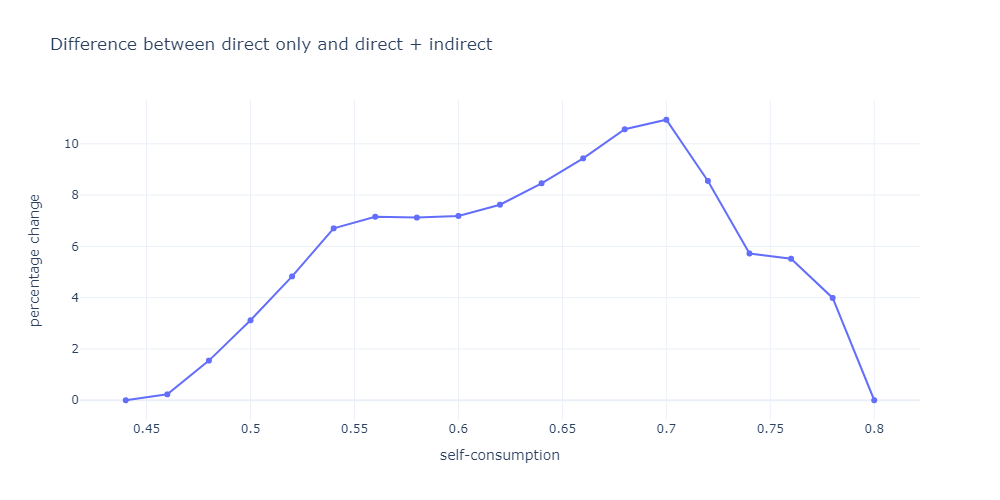

In [24]:
capacity_df["difference"] = capacity_df["direct only"] - capacity_df["direct & indirect"]
fig = px.line(capacity_df,x=capacity_df.index , y = "difference",template = "plotly_white", markers=True,
              title = " Difference between direct only and direct + indirect")
fig.update_layout(hovermode = "x")
fig.update_yaxes(title_text="percentage change")


if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()


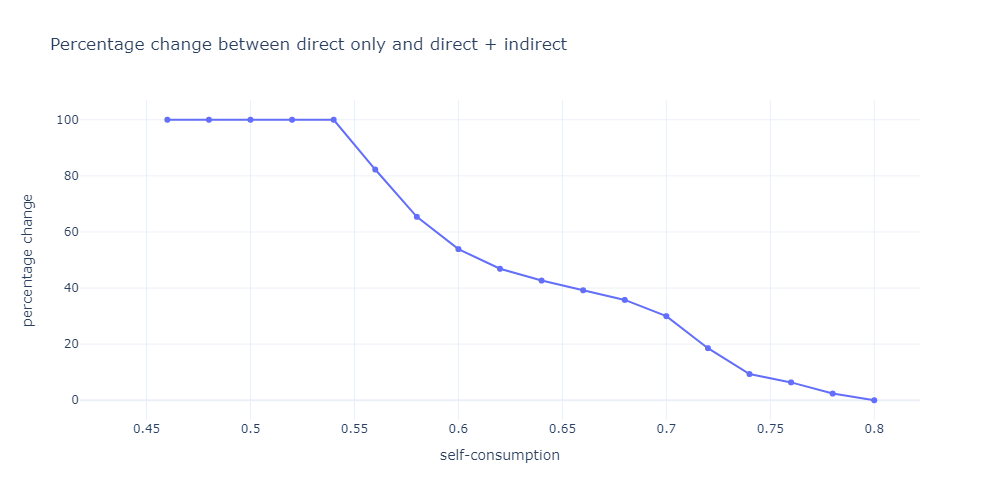

In [25]:
capacity_df["difference"] =((capacity_df["direct only"] - capacity_df["direct & indirect"]) / capacity_df["direct only"]) *100

fig = px.line(capacity_df,x=capacity_df.index , y = "difference",template = "plotly_white", markers=True,
              title = "Percentage change between direct only and direct + indirect")
fig.update_layout(hovermode = "x")
fig.update_yaxes(title_text="percentage change")

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

# Test : charging frequency at 70% self-consumption rate

In [26]:


def test(data_treated = None,optimal = None , period = 24 ):
    
    prod = data_treated[pv].tolist()
    load = data_treated[demand].tolist()
    chg_1 = data_treated[indirect_flex[0]].tolist()
    chg_2 = data_treated[indirect_flex[1]].tolist()
    chg_3 = data_treated[indirect_flex[2]].tolist()
    chg_4 = data_treated[indirect_flex[3]].tolist()
    
    dates =  data_treated.index.tolist()

    results = []
#     print (prod)
    for capacity  in optimal:

        max_dis = -0.8 * capacity
        max_chg =  0.8 * capacity
        ch_eff = 0.95 
        dch_eff = 0.95
        max_soc = 1 * capacity
        min_soc = 0.2* capacity
        
        init = capacity * 0.4

        
        df_ = pd.DataFrame()

        length = int(len(dates)/period)
        if length * period < (len (dates)):
            length += 1
        init_cap = init
        start = dates[0]
        for y in range(length):
#             print (dates)
            end, prodd,datess = d_manager.select_period(start,dates,prod,period,
                                                        name = "PRODUCTION")

            end, loadd,datess = d_manager.select_period(start,dates,load,period,
                                                       name = "DEMAND")

            end, temp,datess = d_manager.select_period(start,dates,chg_1,period,
                                                       name = "CHARGER_1")

            ch_1 = sum(temp) 

            end, temp,datess = d_manager.select_period(start,dates,chg_2,period,
                                                       name = "CHARGER_2")

            ch_2 = sum(temp) 
            
            end, temp,datess = d_manager.select_period(start,dates,chg_3,period,
                                                       name = "CHARGER_3")

            ch_3 = sum(temp) 
            
            end, temp,datess = d_manager.select_period(start,dates,chg_4,period,
                                                       name = "CHARGER_4")
            ch_4 = sum(temp) 

            



            if len(prodd) >= 20 :


                start = end
                model,rslt = optimizer.simulate(max_dis = max_dis ,
                                max_chg = max_chg, ch_eff = 0.95, dch_eff = 0.95,solver = "gurobi",
                                max_soc = max_soc, min_soc = min_soc, prodd = prodd[:],verbose = True,
                                loadd = loadd[:],init_cap = init_cap,ch_1 = ch_1 , ch_2 = ch_2,
                                ch_3 = ch_3 , ch_4 = ch_4, datess = datess)

                df_ = df_.append(rslt)

                init_cap = model.end_cap.value
                print (init_cap)
                sd = 1e-6
                clear_output(wait = True)
            else:
                pass



        results.append (df_)
        clear_output(wait = True)


    print ("OPTIMIZATION SUCCESSFULLY COMPLETED")
    return results

            

In [27]:
optimal =capacity_df [["direct only", "direct & indirect"]].loc[0.70].tolist()

results_optimal = test(data_treated = data_treated.copy(),optimal = optimal , period = 24 )

temp = data_treated[:-10].copy()
temp = temp.rename(columns = {"charger 1" : "charger_1", "charger 2" : "charger_2","charger 3" : "charger_3",
                              "charger 4" : "charger_4"})
results_optimal.append(temp)


freq = pd.DataFrame()
names = ["direct only", "direct & indirect","reference"]
count = 0
for result in results_optimal:

    temp = result.copy()
    try:
        temp = temp.set_index("dates")
    except:
        pass

    temp.where(temp > 0, np.nan, inplace=True)
    temp = temp[["charger_1", "charger_2","charger_3","charger_4"]].groupby(temp.index.hour).count()
    temp["ch"] = temp[["charger_1", "charger_2","charger_3","charger_4"]].sum(axis=1)

    freq[names[count]]  = temp["ch"]
    count += 1

OPTIMIZATION SUCCESSFULLY COMPLETED


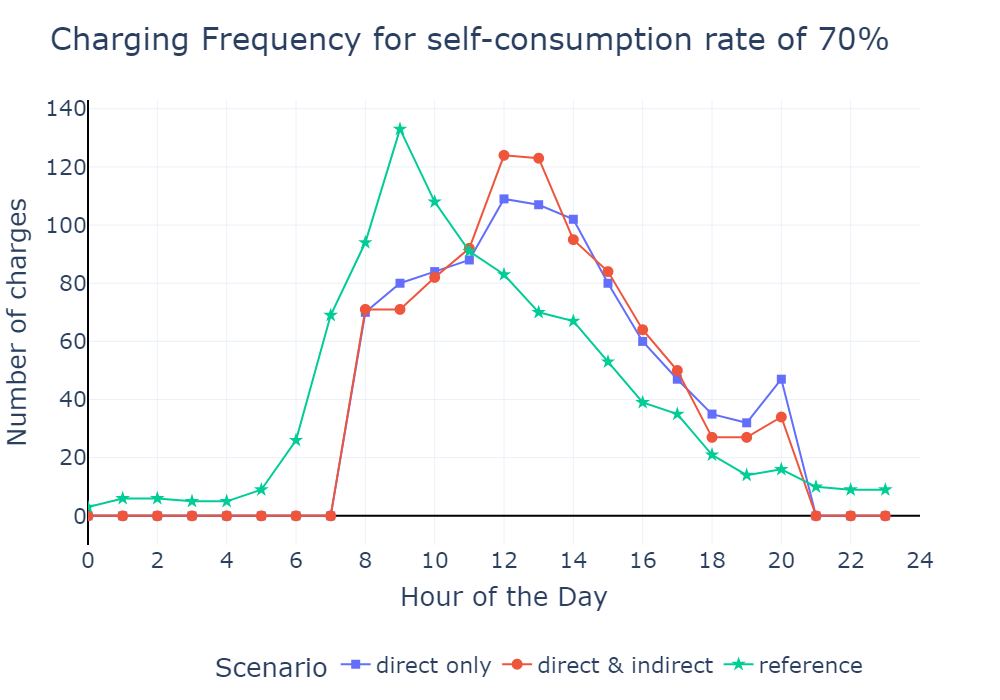

In [28]:
layout = {
   "font":{"size" : 22}, "template": "plotly_white",
    "width" : 1200, "height" : 700,
    'xaxis': {"showline": False,"linecolor": "black", "linewidth": 2,"tickangle" :0,
              'zerolinecolor':'black',"title_text" : "Hour of the Day","dtick": 2, "range": [0,24]
             },
    "yaxis": {"showline": False,"linecolor": "black", "linewidth": 2,
              'zerolinecolor':'black',
               "side": 'left',
              "title_text" : "Number of charges",

    },
    
    "legend" : {"tracegroupgap":4 ,"font_size": 22,"orientation":"h", "yanchor":"bottom",
    "y":-0.32,"x":0.15, "title" : "Scenario"}
}

fig = px.line(freq, template = 'plotly_white', title = "Charging Frequency for self-consumption rate of 70%",
              markers=True)
fig['data'][1]['marker']['size'] = 11
fig['data'][0]['marker']['symbol'] = 'square'
fig['data'][0]['marker']['size'] = 9
fig['data'][2]['marker']['symbol'] = 'star'
fig['data'][2]['marker']['size'] = 11
fig.update_layout(layout)

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### Effort indicator

\begin{equation}
\text { effort }=\frac{\sum_{t} \mid \text { frequncy }_{\text {optimal }}(t)-\text { frequncy }_{\text {reference }}(t) \mid}{\sum_{t} \text { frequncy }_{\text {reference }}(t)}
\end{equation}

In [29]:
effort_1 = (freq["direct only"] - freq["reference"]).abs().sum() / freq["reference"].sum()
effort_2 = (freq["direct & indirect"] - freq["reference"]).abs().sum() / freq["reference"].sum()

print (f"effort required to reach direct only optimal : {round(effort_1, 4)}" )
print (f"effort required to reach direct & indirect optimal : {round(effort_2, 4)}" )

effort required to reach direct only optimal : 0.4913
effort required to reach direct & indirect optimal : 0.5087


## Assess Exponential growth in battery capacity

In [30]:
sc = [ 0.76, 0.78, 0.80]
compare =[capacity_df ["direct & indirect"].loc[x] for x in sc]

results_compare = [results[f"{tags[1]} (sc = {sc[x]})"] for x in range(len(sc))]

# results_compare = test(data_treated = data_treated,optimal = compare , period = 24 )

count = 0
monthly = pd.DataFrame()
for result in results_compare:
    result["self_consumed"] = result["load"] + result["charger_1"] + result["charger_2"] - result["grid_import"]
    temp = result.copy()
#     print (temp)
    temp = temp.resample("1M").sum()
    
    monthly[f"{round(compare[count], 0)} (sc= {sc[count]})"] = ((temp["self_consumed"] / temp["production"]).tolist())
    count += 1
monthly.index = ["Jan","Feb", "March" , "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

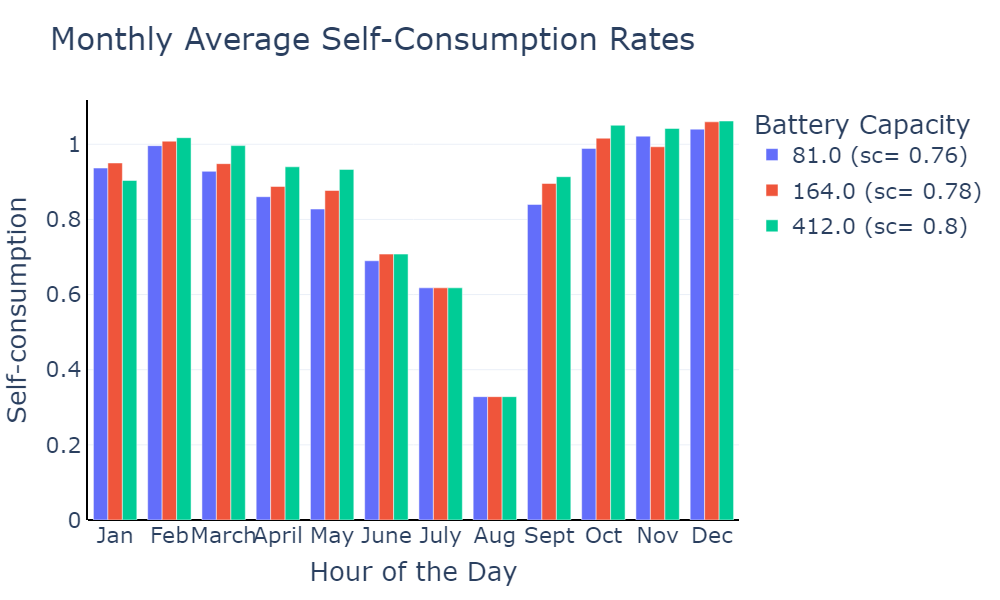

In [31]:
layout = {
   "font":{"size" : 22}, "template": "plotly_white",
    "width" : 1100 , "height" : 600,
    'xaxis': {"showline": False,"linecolor": "black", "linewidth": 2,"tickangle" :0,
              'zerolinecolor':'black',"title_text" : "Hour of the Day","dtick": 1
             },
    "yaxis": {"showline": True,"linecolor": "black", "linewidth": 2,
              'zerolinecolor':'black',
               "side": 'left',
              "title_text" : "Self-consumption",

    },
    
    "legend" : {"tracegroupgap":4 ,"font_size": 22,
                "title" : "Battery Capacity"}
}


fig = px.bar(monthly,title =  "Monthly Average Self-Consumption Rates",
              barmode="group" )
fig.update_layout(layout)

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

## FACT SHEET

Notebook factsheet based on the [OEP scenario factsheet](https://openenergy-platform.org/factsheets/scenarios/)

<style type="text/css">
	table.tableizer-table {
		font-size: 12px;
		border: 1px solid #CCC; 
		font-family: Arial, Helvetica, sans-serif;
	} 
	.tableizer-table td {
		padding: 4px;
		margin: 3px;
		border: 1px solid #CCC;
	}
	.tableizer-table th {
		background-color: #104E8B; 
		color: #FFF;
		font-weight: bold;
	}
</style>
<table class="tableizer-table">
 <tr><td rowspan=21>Study</td>
 <tr><td>&nbsp;</td><td>Name</td><td>Stationary Battery Sizing taking into Account Indirect Flexibility</td></tr>
 <tr><td>&nbsp;</td><td>Author - institution</td><td>Nana Kofi Twum-Duah - G2Elab</td></tr>
 <tr><td>&nbsp;</td><td>Contact</td><td>nana-kofi-baabu.twum-duah@g2elab.grenoble-inp.fr</td></tr>
 <tr><td>&nbsp;</td><td>Client</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Funding</td><td>Public</td></tr>
 <tr><td>&nbsp;</td><td>Citation reference</td><td> N. Twum-Duah, S. Hodencq, M. Amayri S. Ploix, and F. Wurtz, ‘Optimal Sizing of Stationary Battery Storage Taking into Account Indirect Flexibility in Tertiary Buildings: Use case of an Electric Vehicle Community’, Porto, Portugal, June. 2022. Accessed: Sep. 16, 2021. [Online]. Available: https://hal.archives-ouvertes.fr/hal-03341883</td></tr>
 <tr><td>&nbsp;</td><td>Aim</td><td>The Study proposes a method for optimizing the sizing of a stationary battery taking into account the flexibility available from the charging of Electric Vehicles (i.e. the indirect flexibility). A comparison is provided of the same sizing without consideration for the indirect flexibility. Additionaly a metric; the effort indicator is proposed to evaluate the degree of effort required to go from a reference EV charging profile to an optimal one.</td></tr>
 <tr><td>&nbsp;</td><td>New aspects</td><td> Optimal Battery sizing with optimal use of indirect flexibilty</td></tr>
 <tr><td>&nbsp;</td><td>Spatial / Geographical coverage</td><td>Buidling  ; Grenoble</td></tr>
 <tr><td>&nbsp;</td><td>Time frame</td><td>2021</td></tr>
 <tr><td>&nbsp;</td><td>Tools</td><td>Pyomo</td></tr>
 <tr><td>&nbsp;</td><td>Modeled energy sectors</td><td>Electricity</td></tr>
 <tr><td>&nbsp;</td><td>Modeled demand sectors</td><td>Tertiary Sector Building</td></tr>
 <tr><td>&nbsp;</td><td>Economic (behavioural) rationale </td><td>Single fictive decision-maker with perfect knowledge (perfect foresight optimization)</td></tr>
 <tr><td>&nbsp;</td><td>Technologies included </td><td>mono-cristalline PV, Lithium Ion Batteries, Electricity</td></tr>
 <tr><td>&nbsp;</td><td>Economic focuses included</td><td>No</td></tr>
 <tr><td>&nbsp;</td><td>Social focuses included</td><td>No</td></tr>
     <tr><td>&nbsp;</td><td>Endogenous variables</td><td>PV power, Grid power, Battery charging and discharging power, battery energy and capacity, EV charging</td></tr>
 <tr><td>&nbsp;</td><td>Time steps</td><td>Hour</td></tr>
 <tr><td rowspan=7>Empirical data</td>
 <tr><td>&nbsp;</td><td>Exogenous time series used</td><td>Load curves, PV production</td></tr>
 <tr><td>&nbsp;</td><td>Technical data + usage</td><td> battery technical characteristics</td></tr>
 <tr><td>&nbsp;</td><td>Social data</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Economical data</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Ecological data</td><td>None</td></tr>
    <tr><td>&nbsp;</td><td>Pre-Processing</td><td>outlier removal </td></tr>
 <tr><td rowspan=5>Assumptions</td>
<tr><td>&nbsp;</td><td>Energy assumption</td><td> Charging energy required for the given sub-horizon (1 day) must be fulfilled by the proposed EV charging of the optimizer (i.e. the charging of EVs is being optimized)</td></tr>
 <tr><td>&nbsp;</td><td>Environmental assumptions</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Economic assumption</td><td>None</td></tr> 
 <tr><td>&nbsp;</td><td>Post-processing</td><td> computing of the hourly charging frequency and the self consumption rate for the period of evaluation. <tr><td 
rowspan=5>Results</td>
 <tr><td>&nbsp;</td><td>Uncertainty assesment</td><td>No uncertainty analysis has been carried out in this study</td></tr>
 <tr><td>&nbsp;</td><td>Robustness</td><td>Mixed Integer Linear programming (MILP) optimisations as used for this use-case are robust and reproducible.</td></tr>
 <tr><td>&nbsp;</td><td>Comparability / Validation</td><td>None </td></tr>
 <tr><td>&nbsp;</td><td>Conclusions</td><td>Indirect flexibilities (and in extension the "Human in the loop") are a key part of a buildings anergy sub-system and as such should be conidered and taken into account for the dimensioning of other energy-subsytems not only at the building scale.  </td></tr>
</tbody></table>